In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter("ignore")

%matplotlib inline


In [12]:
df_raw = pd.read_csv("water_potability.csv")
df_raw.columns = df_raw.columns.str.lower()

df_raw

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [13]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   hardness         3276 non-null   float64
 2   solids           3276 non-null   float64
 3   chloramines      3276 non-null   float64
 4   sulfate          2495 non-null   float64
 5   conductivity     3276 non-null   float64
 6   organic_carbon   3276 non-null   float64
 7   trihalomethanes  3114 non-null   float64
 8   turbidity        3276 non-null   float64
 9   potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [14]:
df_raw.isna().sum()

ph                 491
hardness             0
solids               0
chloramines          0
sulfate            781
conductivity         0
organic_carbon       0
trihalomethanes    162
turbidity            0
potability           0
dtype: int64

39.01 % of samples are safe to drink (potability==1)


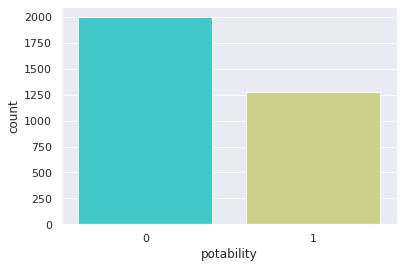

In [16]:
sns.set_theme(style="darkgrid")
sns.countplot(x=df_raw["potability"], palette="rainbow")

print(f'{df_raw.potability[df_raw.potability==1].count()/df_raw.potability.count()*100:.2f} % of samples are safe to drink (potability==1)')

<AxesSubplot:>

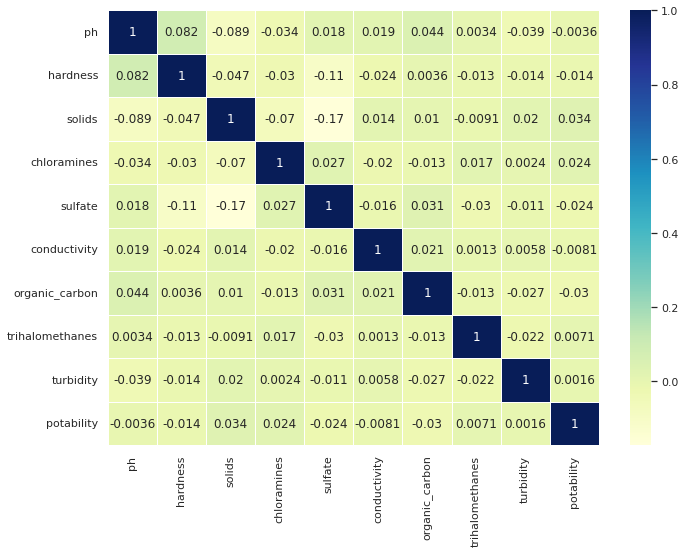

In [25]:
plt.figure(figsize=(11,8))
sns.heatmap(df_raw.corr(), annot=True, cmap='YlGnBu', linewidths=.75)

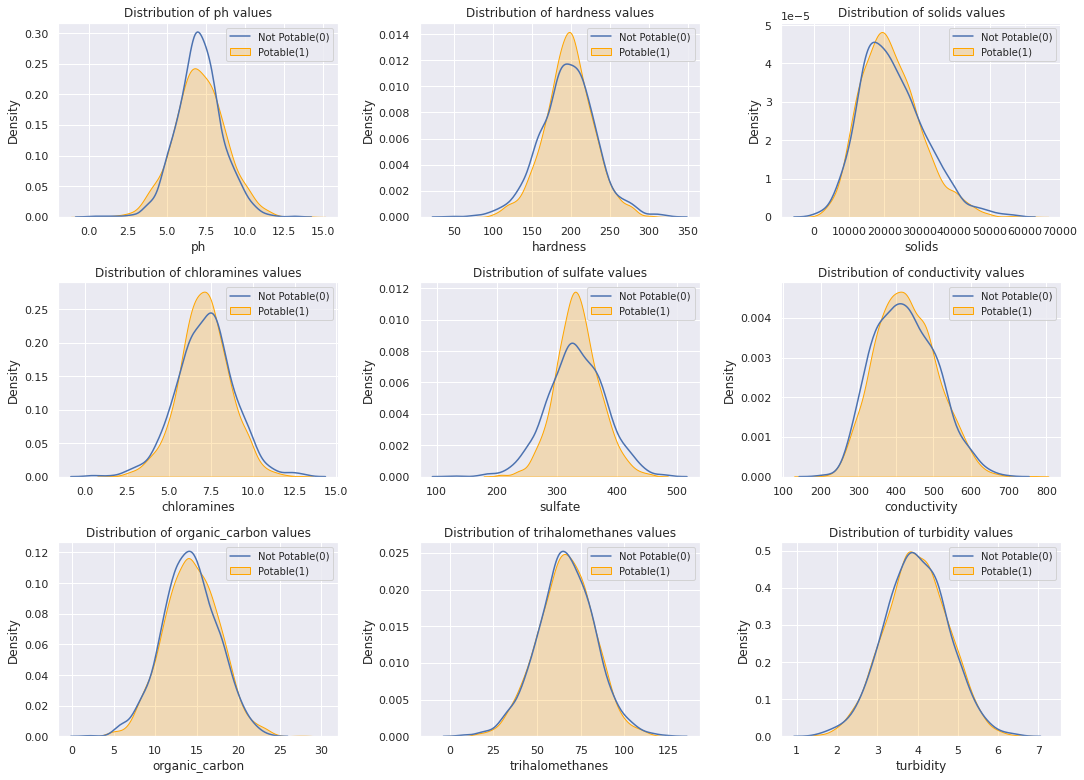

In [29]:
potable = df_raw.query('potability == 0')
not_potable = df_raw.query('potability == 1')

fig = plt.figure(figsize=(15,11))

for ax,column in enumerate(df_raw.columns[:9]):
    plt.subplot(3,3,ax+1)
    plt.title(f'Distribution of {column} values')
    sns.kdeplot(x=not_potable[column],label='Not Potable(0)')
    sns.kdeplot(x=potable[column], color='Orange', shade=True, label='Potable(1)')
    plt.legend(prop=dict(size=10))

plt.tight_layout()

In [30]:
def fill_nan(df):
    for index, column in enumerate(df.columns[:9]):
        df[column] = df[column].fillna(df.groupby('potability')[column].transform('mean'))
    
    return df
        
df = fill_nan(df_raw)

df.isna().sum()                                               

ph                 0
hardness           0
solids             0
chloramines        0
sulfate            0
conductivity       0
organic_carbon     0
trihalomethanes    0
turbidity          0
potability         0
dtype: int64

In [32]:
X = df.drop(['potability'], axis = 1)
y = df['potability']

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=18, stratify=y)

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=42)

# Balancing data - oversampling minority
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)

# Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.fit_transform(X_val)
X_test = sc.transform(X_test)


In [50]:
from tqdm.auto import tqdm

#number of cross-validation folds
cv = 10

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(), 
    "Random Forest": RandomForestClassifier(),                  
    "XgBoost": XGBClassifier(),
    "CatBoost Classifier": CatBoostClassifier()
}

def fit_and_score(models, X_train, X_val, y_train, y_val):
   
    np.random.seed(42)
    model_scores = {}
   
    for name, model in tqdm(models.items()):
        
        model.fit(X_train, y_train)
        model_scores[name] = cross_val_score(model,
                                             X_val,
                                             y_val,
                                            scoring='roc_auc',
                                            cv=cv
                                            ).mean()

    return model_scores

In [54]:
import warnings
warnings.filterwarnings('ignore')

model_scores = fit_and_score(models,X_train,X_val,y_train,y_val)

  0%|          | 0/5 [00:00<?, ?it/s]

[00:30:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [55]:
model_scores

{'Logistic Regression': 0.46332859960552264,
 'Decision Tree': 0.6460256410256411,
 'Random Forest': 0.8057736686390534,
 'XgBoost': 0.8152764299802762,
 'CatBoost Classifier': 0.8339755424063116}

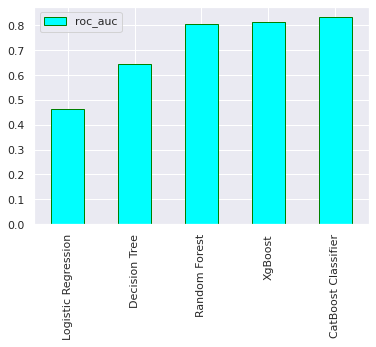

In [64]:
model_compare = pd.DataFrame(model_scores, index=["roc_auc"])
model_compare.T.plot.bar(color='cyan', edgecolor='green');

In [68]:
np.random.seed(42)

xgb_grid = {
    "learning_rate" : [0.01, 0.05, 0.10, 0.20, 0.30],
    "eta" : [0, 0.1, 0.2, 0.3, 0.4],
    "max_depth" : [ 2, 3, 5, 7, 9],
    "min_child_weight" : [ 1, 3, 5, 10]
}

rs_xgb = RandomizedSearchCV(XGBClassifier(),
                                param_distributions=xgb_grid,
                                cv=5,
                                n_iter=100,
                                verbose=0
                               )

# Fit random hyperparameter search model for XGB Classifier
rs_xgb.fit(X_train, y_train)

# Find best hyperparamaters
rs_xgb.best_params_


[00:59:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:59:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:59:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:59:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

{'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.2, 'eta': 0}

In [75]:
rs_xgb.score(X_test, y_test)

0.6158536585365854

In [70]:
model = XGBClassifier(
    learning_rate =0.2,
    eta = 0.1, 
    max_depth=7, 
    min_child_weight=3
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[01:01:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:>

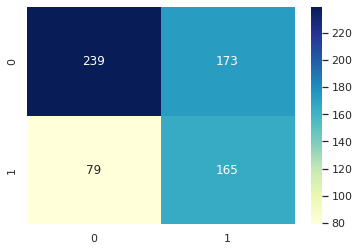

In [71]:
sns.heatmap(confusion_matrix(y_test, y_pred), 
    annot=True, 
    fmt='d', 
    cmap='YlGnBu')


In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.58      0.65       412
           1       0.49      0.68      0.57       244

    accuracy                           0.62       656
   macro avg       0.62      0.63      0.61       656
weighted avg       0.65      0.62      0.62       656



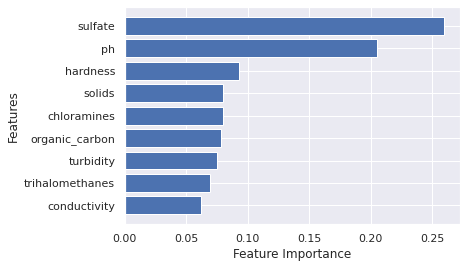

In [74]:
# Feature importance

def plot_features(columns, importances,n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    # Plot dataframe
    fix, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()
    
plot_features(df.drop(['potability'],axis=1).columns, model.feature_importances_)